In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
img_prefix="../datasets/mmbreast/"
dataset = "miniddsm" # "rsna", "vindr", "miniddsm", "cmmd", "cddcesm", "bmcd"
cleaned_images_dir = os.path.join(img_prefix, dataset, "cleaned_images")
list_fd = os.listdir(cleaned_images_dir)
data_list = [
        os.path.join(cleaned_images_dir, f)
        for f in list_fd
        if os.path.isfile(os.path.join(cleaned_images_dir, f))
    ]
print("Number of images: ", len(data_list))

Number of images:  7808


In [3]:
img_skip = 9
assert img_skip < len(data_list), "img_skip should be less than the number of images"
filename = data_list[img_skip]
print(filename)
src_img = cv2.imread(filename)
assert src_img is not None

../datasets/mmbreast/miniddsm/cleaned_images/A_0569_1@A_0569_1|RIGHT|MLO.png


(2736, 1581, 3)


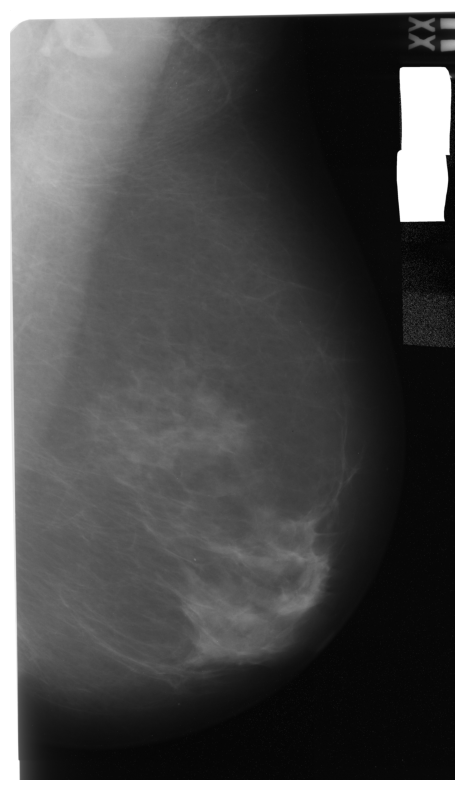

In [4]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(src_img)
print(src_img.shape)

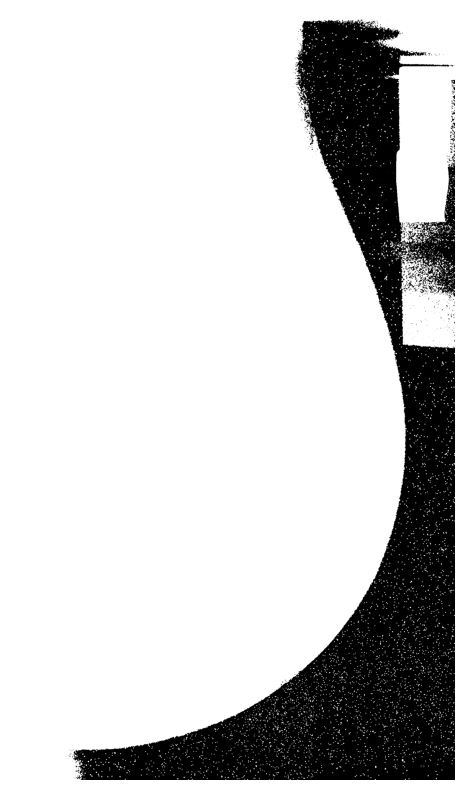

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
# Apply GaussianBlur to smooth the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply a binary threshold to create a binary image
_, binary_mask = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(binary_mask, cmap='gray')

(2736, 1581, 3)


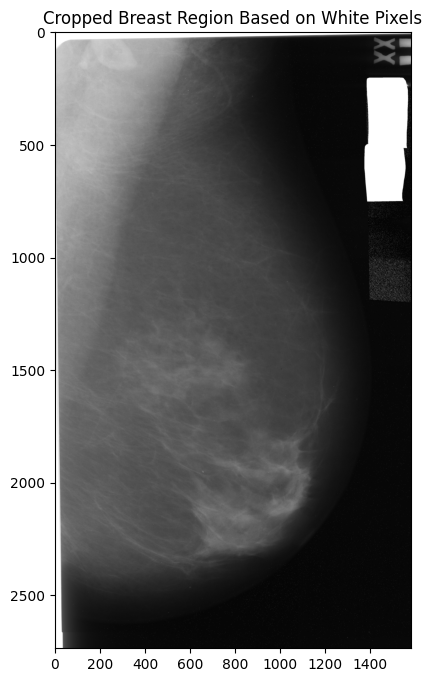

In [6]:
def find_largest_true_sequence_indices(bool_list):
    max_sequence = 0  # To store the maximum length of True values
    current_sequence = 0  # To count the current sequence of True values
    start_index = -1  # To store the start index of the current sequence
    max_start = -1  # To store the start index of the largest sequence
    max_end = -1  # To store the end index of the largest sequence

    for i, value in enumerate(bool_list):
        if value:
            if current_sequence == 0:
                start_index = i  # Mark the start of the sequence
            current_sequence += 1
        else:
            if current_sequence > max_sequence:
                max_sequence = current_sequence
                max_start = start_index
                max_end = i - 1  # End index is the last True index
            current_sequence = 0  # Reset the current sequence

    # In case the list ends with a True sequence
    if current_sequence > max_sequence:
        max_start = start_index
        max_end = len(bool_list) - 1  # End index is the last True index

    return (max_start, max_end)


# Function to find crop boundaries based on white pixel percentage
def find_breast_region_edges(binary_mask, white_pixel_threshold=0.3):
    binary_mask[binary_mask==255] = 1
    sum_rows = np.sum(binary_mask, axis=1)
    threshhold_row = np.mean(sum_rows) * white_pixel_threshold
    sum_cols = np.sum(binary_mask, axis=0)
    threshhold_col = np.mean(sum_cols) * white_pixel_threshold
    sum_rows[sum_rows < threshhold_row] = False
    sum_rows[sum_rows > threshhold_row] = True
    sum_cols[sum_cols < threshhold_col] = False
    sum_cols[sum_cols > threshhold_col] = True
    # Initialize edges
    top, bottom = find_largest_true_sequence_indices(sum_rows)
    left, right = find_largest_true_sequence_indices(sum_cols)
    return top, bottom, left, right

# Get the crop boundaries based on the binary mask
top, bottom, left, right = find_breast_region_edges(binary_mask, 0.1)

# Crop the original image based on the calculated edges
cropped_image = src_img[top:bottom+1, left:right+1]
print(cropped_image.shape)

# Show the cropped breast region
plt.figure(figsize=(8, 8))
plt.title("Cropped Breast Region Based on White Pixels")
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))  # If the original image is in color
plt.show()


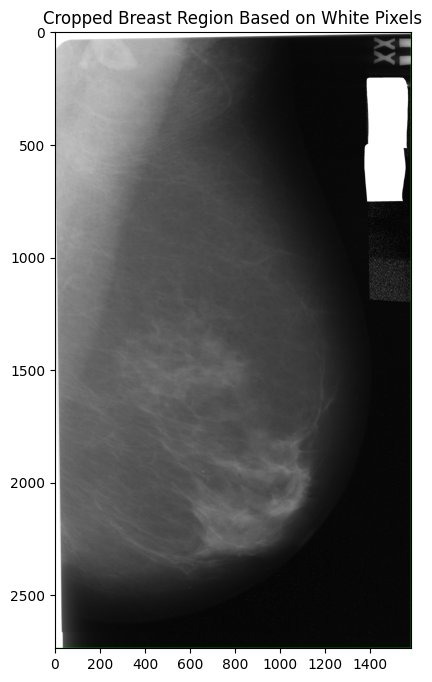

In [7]:
def get_largest_connected_region_bbox(binary_image):
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

    # Stats format: [x, y, width, height, area] for each component
    # The first label is the background, so we start from index 1
    largest_label = 1
    largest_area = stats[1, cv2.CC_STAT_AREA]  # Initialize with first component

    for i in range(2, num_labels):  # Start from the second component
        area = stats[i, cv2.CC_STAT_AREA]
        if area > largest_area:
            largest_label = i
            largest_area = area

    # Get the bounding box of the largest component
    x = stats[largest_label, cv2.CC_STAT_LEFT]
    y = stats[largest_label, cv2.CC_STAT_TOP]
    w = stats[largest_label, cv2.CC_STAT_WIDTH]
    h = stats[largest_label, cv2.CC_STAT_HEIGHT]

    # Return the bounding box (x, y, w, h)
    return (x, y, w, h)

x, y, w, h = get_largest_connected_region_bbox(binary_mask)

# Draw the bounding box on the image for visualization
image_with_bbox = src_img.copy()
cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box

# Display the result
plt.figure(figsize=(8, 8))
plt.title("Cropped Breast Region Based on White Pixels")
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # If the original image is in color
plt.show()